In [31]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


In [32]:
serie_A_data = pd.read_csv('SerieA.csv', delimiter=',')

In [33]:
print(serie_A_data.head())

   yyyy-mm-dd  HH:MM     team1     team2  score1  score2
0  2018-08-18  18:00    Chievo  Juventus       2       3
1  2018-08-18  20:30     Lazio    Napoli       1       2
2  2018-08-19  18:00    Torino      Roma       0       1
3  2018-08-19  20:30  Sassuolo     Inter       1       0
4  2018-08-19  20:30     Parma   Udinese       2       2


In [42]:
def get_posterior(initial_point, num_samples, y, beta_inv, m_s, sigma_s):

    point = np.array(initial_point)
    samples = np.empty([num_samples+1, 2]) 
    samples[0] = point

    for i in range(num_samples):
        s1_sample, s2_sample = samples[i]
        if y==1:
            t = stats.truncnorm.rvs(a=0, b=np.inf, loc=(s1_sample - s2_sample), scale=np.sqrt(beta_inv))  # p(t|s1, s2, y)
        elif y==-1:
            t = stats.truncnorm.rvs(a=-np.inf, b=0, loc=(s1_sample - s2_sample), scale=np.sqrt(beta_inv))
        A = np.array([[1, -1]])
        S = np.linalg.inv(np.linalg.inv(sigma_s) + (beta_inv)**(-1) * (A.T @ A))
        m = S @ (np.linalg.inv(sigma_s) @ m_s + beta_inv**(-1) * A.T * t)

        point = np.random.multivariate_normal(m.ravel(), S)
        samples[i+1] = point

    return m[0][0], m[1][0], S[0,0], S[1,1], point

In [57]:
beta_inv = 0.5
num_samples = 2000
mu_0 = 25.0
sigma_0 = 40.0

unique_teams = pd.concat([serie_A_data['team1'], serie_A_data['team2']]).unique()
skills_df = pd.DataFrame({'team': unique_teams,
    'mu': [mu_0] * len(unique_teams),
    'sigma': [sigma_0] * len(unique_teams),
    's' : np.random.normal(mu_0, sigma_0)
})
skills_history = {team: [(mu_0, sigma_0)] for team in list(unique_teams)}
#skills_history = {team: [skills_df.loc[skills_df['team'] == team, 's'].values[0]] for team in list(unique_teams)}

for _, match_instance in tqdm(serie_A_data.iterrows(), total=serie_A_data.shape[0], desc="Processing Matches", leave=True, position=0, unit='match'):
    team1, team2, score1, score2 = match_instance['team1'], match_instance['team2'], match_instance['score1'], match_instance['score2']
    if score1 == score2:
        continue
    
    mu1 = skills_df.loc[skills_df['team'] == team1, 'mu'].values[0]
    sigma1 = skills_df.loc[skills_df['team'] == team1, 'sigma'].values[0]
    mu2 = skills_df.loc[skills_df['team'] == team2, 'mu'].values[0]
    sigma2 = skills_df.loc[skills_df['team'] == team2, 'sigma'].values[0]
    s1 = skills_df.loc[skills_df['team'] == team1, 's'].values[0]
    s2 = skills_df.loc[skills_df['team'] == team2, 's'].values[0]

    if s2>s1:#mu2 > mu1:
        mu1, mu2 = mu2, mu1
        sigma1, sigma2 = sigma2, sigma1
        team1, team2 = team2, team1
        score1, score2 = score2, score2
        s1, s2 = s2, s1
    
    if score1 > score2:
        y=1
    else:
        y=-1
    
    mu1_new, mu2_new, sigma1_new, sigma2_new, point = get_posterior(initial_point = [s1, s2],
                                                            num_samples = num_samples,
                                                            y = y,
                                                            beta_inv = beta_inv,
                                                            m_s = np.array([[mu1], [mu2]]),
                                                            sigma_s = np.array([[sigma1, 0], [0, sigma2]]))
    
    skills_history[team1].append((mu1_new, sigma1_new))
    skills_history[team2].append((mu2_new, sigma2_new))

    skills_df.loc[skills_df['team'] == team1, 'mu'] = mu1_new
    skills_df.loc[skills_df['team'] == team1, 'sigma'] = sigma1_new
    skills_df.loc[skills_df['team'] == team2, 'mu'] = mu2_new
    skills_df.loc[skills_df['team'] == team2, 'sigma'] = sigma2_new
    skills_df.loc[skills_df['team'] == team1, 's'] = point[0]
    skills_df.loc[skills_df['team'] == team2, 's'] = point[1]


Processing Matches: 100%|██████████| 380/380 [08:19<00:00,  1.31s/match]


c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

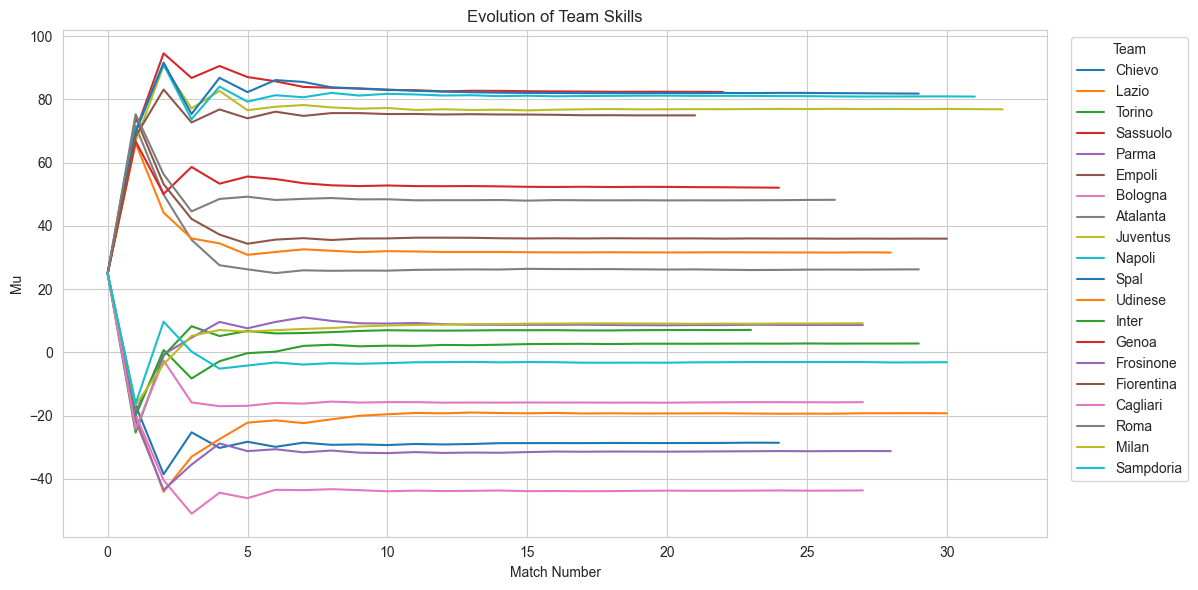

In [58]:

plt.figure(figsize=(12, 6))
ax = plt.gca()

sns.set_style("whitegrid")

for team, mu_sigma_values in skills_history.items():
    mu_values = [mu for mu, sigma in mu_sigma_values]
    x_values = range(len(mu_values))
    sns.lineplot(x=x_values, y=mu_values, ax=ax, label=team)

plt.title("Evolution of Team Skills")
plt.xlabel('Match Number')
plt.ylabel('Mu')
plt.legend(title='Team', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

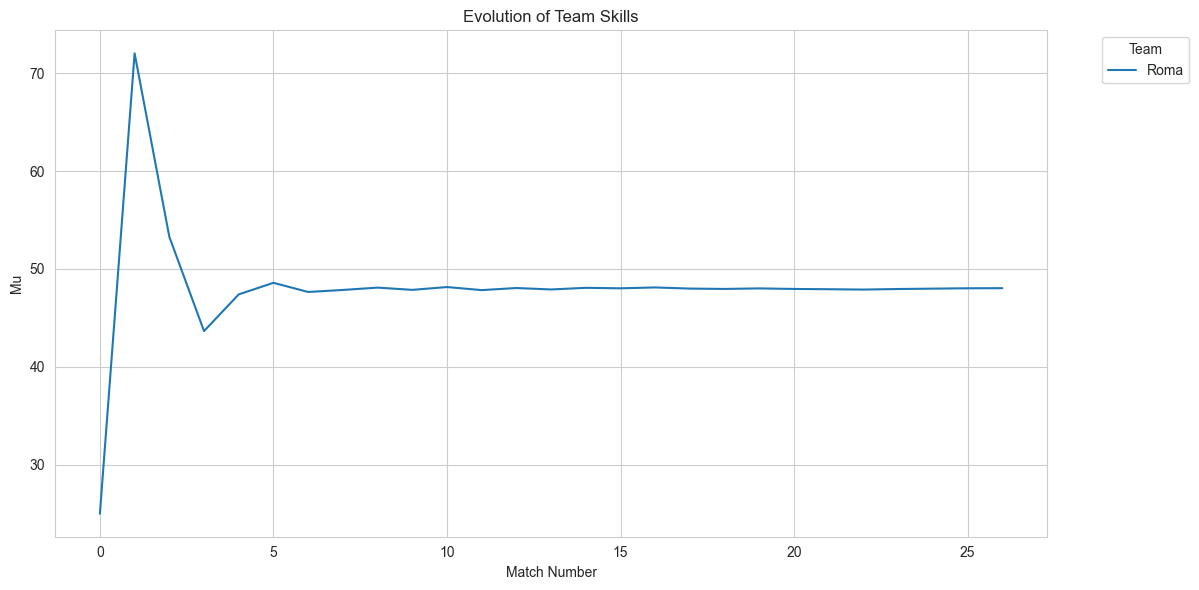

In [55]:
plt.figure(figsize=(12, 6))
ax = plt.gca()

sns.set_style("whitegrid")

# for team, mu_sigma_values in skills_history.items():
#     mu_values = [mu for mu, sigma in mu_sigma_values]
#     x_values = range(len(mu_values))
#     sns.lineplot(x=x_values, y=mu_values, ax=ax, label=team)
mu_sigma_values = skills_history['Roma']
mu_values = [mu for mu, sigma in mu_sigma_values]
x_values = range(len(mu_values))
sns.lineplot(x=x_values, y=mu_values, ax=ax, label='Roma')
plt.title("Evolution of Team Skills")
plt.xlabel('Match Number')
plt.ylabel('Mu')
plt.legend(title='Team', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
sorted_skills_df = skills_df.sort_values(by='mu', ascending=False)

for i, (index, row) in enumerate(sorted_skills_df.iterrows()):
    team = row['team']
    mu = row['mu']
    sigma = row['sigma']
    print(f"{i:2d} -- Team: {team:<15s} | mu: {mu:>7.2f} | sigma: {sigma:>7.2f}")

 0 -- Team: Sassuolo        | mu:   82.38 | sigma:    0.04
 1 -- Team: Spal            | mu:   81.87 | sigma:    0.03
 2 -- Team: Napoli          | mu:   80.92 | sigma:    0.02
 3 -- Team: Juventus        | mu:   76.90 | sigma:    0.02
 4 -- Team: Fiorentina      | mu:   74.98 | sigma:    0.04
 5 -- Team: Genoa           | mu:   52.11 | sigma:    0.03
 6 -- Team: Roma            | mu:   48.27 | sigma:    0.03
 7 -- Team: Empoli          | mu:   35.98 | sigma:    0.02
 8 -- Team: Udinese         | mu:   31.60 | sigma:    0.03
 9 -- Team: Atalanta        | mu:   26.27 | sigma:    0.02
10 -- Team: Milan           | mu:    9.21 | sigma:    0.03
11 -- Team: Parma           | mu:    8.66 | sigma:    0.03
12 -- Team: Torino          | mu:    7.12 | sigma:    0.03
13 -- Team: Inter           | mu:    2.82 | sigma:    0.03
14 -- Team: Sampdoria       | mu:   -3.10 | sigma:    0.02
15 -- Team: Cagliari        | mu:  -15.73 | sigma:    0.03
16 -- Team: Lazio           | mu:  -19.25 | sigma:    0.